In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
def get_all_contour(img):
    ref_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(ref_gray, 127, 255, 0) 

    im2, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE )
    return contours

def get_ref_contour(img):
    contours = get_all_contour(img)

    for contour in contours: 
        area = cv2.contourArea(contour) 
        img_area = img.shape[0] * img.shape[1] 
        if 0.05 < area/float(img_area) < 0.8: 
            return contour
        
def run_grabcut(img_org, rect_final):
    #creat mask
    mask = np.zerose(img_org.shape[:-1], np.uint8)
    x, y, w, h = rect_final
    mask[y:y+h, x:x+h] = 1
    
    #creat backgroung and foreground
    background = np.zeros((1, 65), np.float32)
    foreground = np.zeros((1, 65), np.float32)
    
    #run grabcut
    cv2.grabCut(img_org, mask, rect_final, background, foreground, 5, cv2.GC_INIT_WITH_RECT)
    
    new_mask = np.where((mask==0)|(mask==2),0,1).astype('uint8')
    img_org = img_org[:,:,np.newaxis]
    
    plt.imshow(img_org)
    plt.title('Output', fontsize=20, color='b')
    plt.show()
    
def draw_rectangle(event, x, y, flag, param):
    global x_in, y_in, drawing, top_left, button_right, img_org
    
    #detect mouse
    if event == cv2.LBUTTONDOWN:
        drawing=True
        x_in, y_in = x, y
        
    #mouse move
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            top_left, buttom_right = (x_in, y_in), (x, y)
            img[y_init:y, x__init:x] = 255-img_org[y_init:y, x__init:x]
            cv2.rectangle(img, top_left, buttom_right, (0,255,255), 3)
            
    elif event == cv2.EVENT_LBUTTONUP:
        drawing=False
        top_left, buttom_right = (x_in, y_in), (x, y)
        img[y_init:y, x__init:x] = 255-img[y_init:y, x__init:x]
        cv2.rectangle(img, top_left, buttom_right, (0,255,255), 3)
        rect_final = (x_in, y_in, x-x_in, y-y_in)
        
        run_grabcut(img_org, rect_final)

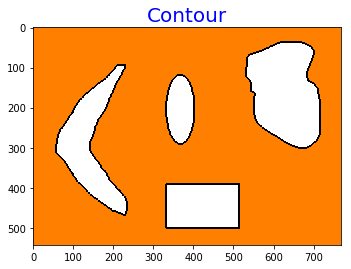

Contour 0 matchs in 0.722
Contour 1 matchs in 0.512
Contour 2 matchs in 0.091
Contour 3 matchs in 1.436


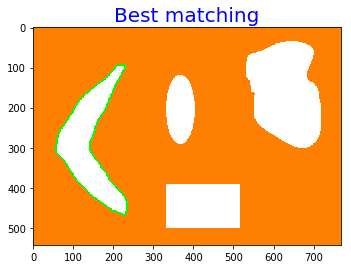

In [3]:
#counter matching
def contours(all_shape, shape):
    img1 = cv2.imread(all_shape)
    img2 = cv2.imread(shape)
    
    shapes = get_all_contour(img1)
    shape = get_ref_contour(img2)
    
    closest = None
    min_dist = None
    contour = img1.copy()
    
    
    cv2.drawContours(contour, shapes, -1, color=(0,0,0), thickness=3)
    
    plt.imshow(contour)
    plt.title('Contour', fontsize=20, color='b')
    plt.show()

    #find the closest contour
    for i, contour_ in enumerate(shapes):
        ret = cv2.matchShapes(shape, contour_, 3, 0.0)
        print('Contour %d matchs in %.3f' %(i, ret))
        
        if min_dist is None or ret < min_dist:
            min_dist = ret
            closest = contour_
            
    cv2.drawContours(img1, [closest], 0, color=(0,255,0), thickness=3)
    
    plt.imshow(img1)
    plt.title('Best matching', fontsize=20, color='b')
    plt.show()
    
    
contours('./images/shapes.png', './images/boomerang.png')

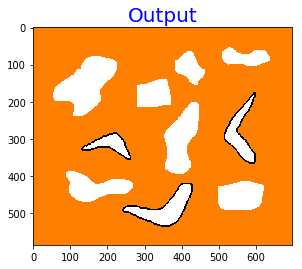

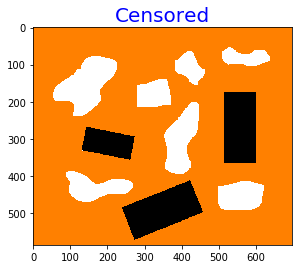

In [4]:
#censor shape
def censor_shape(img):
    img = cv2.imread(img)
 
    img_orig = np.copy(img) 
    input_contours = get_all_contour(img) 
    solidity_values = [] 
 
    # Compute solidity factors of all the contours 
    for contour in input_contours: 
        area_contour = cv2.contourArea(contour) 
        convex_hull = cv2.convexHull(contour) 
        area_hull = cv2.contourArea(convex_hull) 
        solidity = float(area_contour)/area_hull 
        solidity_values.append(solidity) 
 
    # Clustering using KMeans 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) 
    flags = cv2.KMEANS_RANDOM_CENTERS 
    solidity_values = np.array(solidity_values).reshape((len(solidity_values),1)).astype('float32') 
    compactness, labels, centers = cv2.kmeans(solidity_values, 2, None, criteria, 10, flags) 
 
    closest_class = np.argmin(centers) 
    output_contours = [] 
    for i in solidity_values[labels==closest_class]: 
        index = np.where(solidity_values==i)[0][0] 
        output_contours.append(input_contours[index]) 
 
    cv2.drawContours(img, output_contours, -1, (0,0,0), 3)
    
    plt.imshow(img)
    plt.title('Output', fontsize=20, color='b')
    plt.show()
 
    # Censoring 
    for contour in output_contours: 
        rect = cv2.minAreaRect(contour) 
        box = cv2.boxPoints(rect) 
        box = np.int0(box) 
        cv2.drawContours(img_orig,[box],0, (0,0,0), -1) 
 
    plt.imshow(img_orig)
    plt.title('Censored', fontsize=20, color='b')
    plt.show()
    
censor_shape('./images/random_shapes.png')    

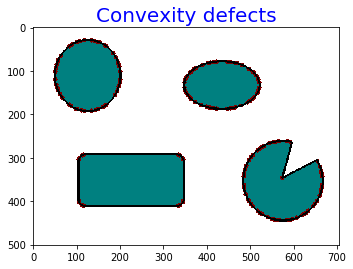

In [5]:
#convexity
def convexity(img):
    img = cv2.imread(img)
    
    for contour in get_all_contour(img):
        hull = cv2.convexHull(contour, returnPoints=False)
        defect = cv2.convexityDefects(contour, hull)
        
        if defect is None:
            continue
        
        for i in range(defect.shape[0]):
            start_defect, end_defect, far_defect, _ = defect[i, 0]
            start = tuple(contour[start_defect][0])
            end = tuple(contour[end_defect][0])
            far = tuple(contour[far_defect][0])
            cv2.circle(img, far, 5, [128,0,0], -1)
            cv2.drawContours(img, [contour], 0, color=(0,0,0), thickness=3)
    plt.imshow(img)
    plt.title('Convexity defects', fontsize=20, color='b')
    plt.show()

    
convexity('./images/convex_shapes.png')

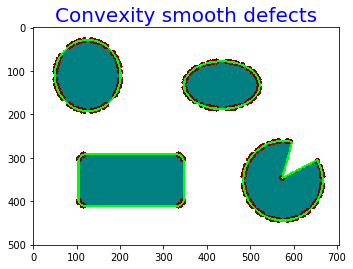

In [6]:
#convex smooth

def convex_smooth(img):
    img = cv2.imread(img)
    
    factor = 0.0001
    
    for contour in get_all_contour(img):
        org_contour = contour
        epl = factor * cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, epl, True)
        
        hull = cv2.convexHull(contour, returnPoints=False)
        defect = cv2.convexityDefects(contour, hull)
        
        if defect is None:
            continue
        
        for i in range(defect.shape[0]):
            start_defect, end_defect, far_defect, _ = defect[i, 0]
            start = tuple(contour[start_defect][0])
            end = tuple(contour[end_defect][0])
            far = tuple(contour[far_defect][0])
            cv2.circle(img, far, 7, [128,0,0], -1)
            cv2.drawContours(img, [org_contour], -1, color=(0,0,0), thickness=3)
            cv2.drawContours(img, [contour], -1, color=(0,255,0), thickness=3)
            
    plt.imshow(img)
    plt.title('Convexity smooth defects', fontsize=20, color='b')
    plt.show()
    
convex_smooth('./images/convex_shapes.png')

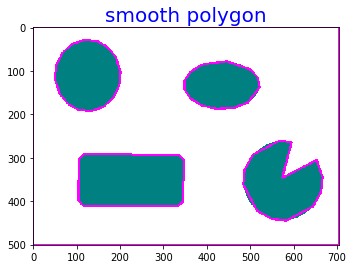

In [7]:
#smooth polygon
def smoothen(img):
    img = cv2.imread(img)

    input_contours = get_all_contour(img) 

    contour_img = img.copy()
    smoothen_contour=[]
    factor = 0.01
    
    for contour in input_contours:
        epl = factor * cv2.arcLength(contour, True)
        smoothen_contour.append(cv2.approxPolyDP(contour, epl, True))
    
    cv2.drawContours(contour_img, smoothen_contour, -1, color=(255,0,255), thickness=3)
    
    plt.imshow(contour_img)
    plt.title('smooth polygon', fontsize=20, color='b')
    plt.show()

smoothen('./images/convex_shapes.png')

In [8]:
#segmention object
def segmentation(img):
    img_org = cv2.imread(img)
    img = img_org.copy()
    
    drawing = False
    top_left = bottom_right = (-1,-1)
    
    cv2.namedWindow('Input')
    cv2.setMouseCallback("Input", draw_rectangle)
    
    while True:
        cv2.imshow('Input', img)
        c = cv2.waitKey(1)
        
        if c == 27:
            break
        
        
# segmentation('./images/hand_pen.jpg')        

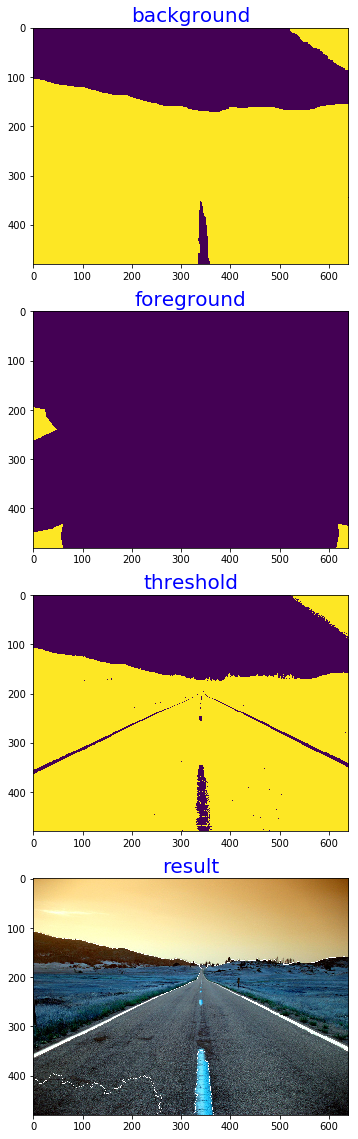

In [15]:
#watershed
def watershed(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    #NOISE remove
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=4)
    #background area
    background = cv2.dilate(opening, kernel, iterations=4)
    
    #find foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, foreground = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    foreground = np.uint8(foreground)
    
    #find unknown area
    unknown = cv2.subtract(background, foreground)
    
    #labeling
    ret, market = cv2.connectedComponents(foreground)
    
    market = market + 1
    
    #unknown region with 0
    market[unknown==255] = 0
    market = cv2.watershed(img, market)
    img[market==-1] = [255,255,255]
    
    fig, ax = plt.subplots(4,1, figsize=(40,20))
    ax[0].imshow(background)
    ax[0].set_title('background', fontsize=20, color='b')

    ax[1].imshow(foreground)
    ax[1].set_title('foreground', fontsize=20, color='b')

    ax[2].imshow(threshold)
    ax[2].set_title('threshold', fontsize=20, color='b')

    ax[3].imshow(img)
    ax[3].set_title('result', fontsize=20, color='b')

    plt.show()

watershed('./images/road.jpg')    